In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [10]:
data_dir = '/home/bern/Development/ai/data-release/datasets/public_dataset/requests_minute'

In [11]:
all_files = []
for filename in os.listdir(data_dir):
    if filename.endswith('.csv'): # Garante que você só pegue arquivos CSV
        filepath = os.path.join(data_dir, filename)
        all_files.append(pd.read_csv(filepath))

In [12]:
df = pd.concat(all_files, ignore_index=True)
df = df.rename(columns={'time': 'timestamp_seconds'})
start_date_base = pd.to_datetime('2020-04-01 00:00:00')
df['datetime_index'] = start_date_base + pd.to_timedelta(df['timestamp_seconds'], unit='s')
df = df.set_index('datetime_index')
if 'day' in df.columns:
    df = df.drop(columns=['day'])
df = df.drop(columns=['timestamp_seconds'])


In [13]:
df_filled = df.fillna(0)
print(df_filled.head())
print(df.info())
print(df_filled.isnull().sum().sum()) # Deve ser 0 agora

                       0    1    2     3     4    5     6    7    8     9  \
datetime_index                                                              
2020-04-08 00:00:00  0.0  0.0  0.0  8529  7543  0.0  1108  0.0  0.0  2246   
2020-04-08 00:01:00  0.0  0.0  0.0  7309  6515  0.0  1027  0.0  0.0  2070   
2020-04-08 00:02:00  0.0  0.0  0.0  6357  5729  0.0  1214  0.0  0.0  1763   
2020-04-08 00:03:00  0.0  0.0  0.0  5452  4869  0.0  1265  0.0  0.0  1561   
2020-04-08 00:04:00  0.0  0.0  0.0  5336  4741  0.0  1124  0.0  0.0  1745   

                     ...  5083  5084  5085  5086  5087  5088  5089  5090  \
datetime_index       ...                                                   
2020-04-08 00:00:00  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2020-04-08 00:01:00  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2020-04-08 00:02:00  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2020-04-08 00:03:00  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2020

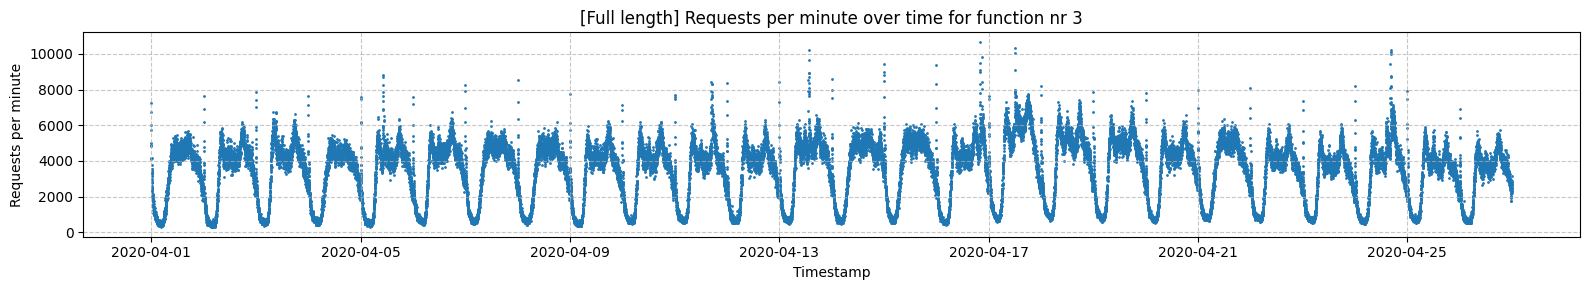

In [14]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(16, 3))
plt.scatter(df_filled.index, df_filled['3'], s=1) # X é o índice datetime, Y é a coluna '3'
plt.xlabel('Timestamp') # Agora é um datetime, nao apenas segundos
plt.ylabel('Requests per minute')
plt.title('[Full length] Requests per minute over time for function nr 3')
plt.grid(True, linestyle='--', alpha=0.7) # Adicionando um grid para melhor leitura
plt.tight_layout() # Ajusta o layout para evitar sobreposições
plt.show()

In [18]:
# Importe a biblioteca necessária
from sklearn.preprocessing import MinMaxScaler
import numpy as np # Para o reshape

# Supondo que 'df_clean' é o seu DataFrame com o índice datetime e NaNs preenchidos com 0
# E que '3' é a coluna da sua função de interesse
series_3 = df_filled['3']

# Verifique a forma atual da série
print(f"Shape original da série 3: {series_3.shape}")

# Reshape a série para 2D, como o MinMaxScaler espera
# O -1 significa "descobrir o tamanho automaticamente", e o 1 significa 1 coluna
series_3_reshaped = series_3.values.reshape(-1, 1) # .values para pegar o array numpy subjacente

print(f"Shape da série 3 após reshape: {series_3_reshaped.shape}")

# Crie o MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1)) # Escala entre 0 e 1

# Aplique o fit_transform para normalizar os dados
scaled_series_3 = scaler.fit_transform(series_3_reshaped)

print(f"\nPrimeiros 5 valores da série 3 normalizada:\n{scaled_series_3[:5]}")

Shape original da série 3: (37440,)
Shape da série 3 após reshape: (37440, 1)

Primeiros 5 valores da série 3 normalizada:
[[0.79266302]
 [0.67550178]
 [0.5840776 ]
 [0.497167  ]
 [0.48602708]]


In [19]:
# Supondo que 'scaled_series_3' é o array numpy 2D normalizado da função 3

total_samples = len(scaled_series_3)

# Definir as proporções
train_ratio = 0.70
val_ratio = 0.15
test_ratio = 0.15 # O restante

# Calcular os tamanhos dos conjuntos
train_size = int(total_samples * train_ratio)
val_size = int(total_samples * val_ratio)
# O test_size pode ser calculado como o restante para evitar erros de arredondamento
test_size = total_samples - train_size - val_size

# Dividir os dados
train_data = scaled_series_3[0:train_size, :]
val_data = scaled_series_3[train_size:train_size + val_size, :]
test_data = scaled_series_3[train_size + val_size:total_samples, :]

print(f"\nTamanho total dos dados: {total_samples}")
print(f"Tamanho dos dados de treino: {len(train_data)}")
print(f"Tamanho dos dados de validação: {len(val_data)}")
print(f"Tamanho dos dados de teste: {len(test_data)}")


Tamanho total dos dados: 37440
Tamanho dos dados de treino: 26208
Tamanho dos dados de validação: 5616
Tamanho dos dados de teste: 5616


In [20]:
def create_sequences(data, look_back):
    x_lista = []
    y_lista = []
    for i in range(look_back, len(data)):
        x_lista.append(data [i - look_back : i, 0])
        y_lista.append(data[i, 0])
    y_numpy_array = np.array(y_lista).reshape(-1, 1)
    x_numpy_array = np.array(x_lista).reshape(-1, look_back, 1)
    return x_numpy_array, y_numpy_array

In [21]:
# Definição dos hiperparâmetros da sequência
look_back_window = 1440 # 24 horas de dados passados
forecast_horizon = 1    # Prever o próximo minuto

# Criar as sequências para cada conjunto de dados
X_train, y_train = create_sequences(train_data, look_back_window)
X_val, y_val = create_sequences(val_data, look_back_window)
X_test, y_test = create_sequences(test_data, look_back_window)

# Imprimir as shapes para verificar
print(f"Shape de X_train: {X_train.shape}")
print(f"Shape de y_train: {y_train.shape}")
print(f"Shape de X_val: {X_val.shape}")
print(f"Shape de y_val: {y_val.shape}")
print(f"Shape de X_test: {X_test.shape}")
print(f"Shape de y_test: {y_test.shape}")

Shape de X_train: (24768, 1440, 1)
Shape de y_train: (24768, 1)
Shape de X_val: (4176, 1440, 1)
Shape de y_val: (4176, 1)
Shape de X_test: (4176, 1440, 1)
Shape de y_test: (4176, 1)


In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input

In [28]:
input_shape = (X_train.shape[1], X_train.shape[2]) # (1440, 1)
model = Sequential([
  Input(shape=input_shape),
  LSTM(units=50, activation='relu'),
  Dropout(0.2),
  Dense(units=forecast_horizon)
])
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
history = model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_val, y_val),
    verbose=1 # Para ver o progresso do treinamento
)

Epoch 1/50


2025-08-03 18:17:18.440041: I external/local_xla/xla/service/service.cc:163] XLA service 0x56411370c940 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-08-03 18:17:18.440057: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2025-08-03 18:17:18.465815: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-08-03 18:17:18.596139: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91100
2025-08-03 18:17:18.673511: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-08-03 18:17:18.

  1/387 ━━━━━━━━━━━━━━━━━━━━ 30:37 5s/step - loss: 0.1059

I0000 00:00:1754255842.330506   22213 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


387/387 ━━━━━━━━━━━━━━━━━━━━ 39s 89ms/step - loss: 0.0079 - val_loss: 0.0020
Epoch 2/50
387/387 ━━━━━━━━━━━━━━━━━━━━ 33s 86ms/step - loss: 0.0027 - val_loss: 0.0019
Epoch 3/50
387/387 ━━━━━━━━━━━━━━━━━━━━ 33s 85ms/step - loss: 0.0024 - val_loss: 0.0018
Epoch 4/50
387/387 ━━━━━━━━━━━━━━━━━━━━ 33s 85ms/step - loss: 0.0022 - val_loss: 0.0017
Epoch 5/50
387/387 ━━━━━━━━━━━━━━━━━━━━ 33s 85ms/step - loss: 0.0020 - val_loss: 0.0016
Epoch 6/50
387/387 ━━━━━━━━━━━━━━━━━━━━ 34s 87ms/step - loss: 0.0019 - val_loss: 0.0016
Epoch 7/50
387/387 ━━━━━━━━━━━━━━━━━━━━ 33s 85ms/step - loss: 0.0019 - val_loss: 0.0015
Epoch 8/50
387/387 ━━━━━━━━━━━━━━━━━━━━ 33s 85ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 9/50
387/387 ━━━━━━━━━━━━━━━━━━━━ 34s 87ms/step - loss: 0.0018 - val_loss: 0.0014
Epoch 10/50
387/387 ━━━━━━━━━━━━━━━━━━━━ 33s 85ms/step - loss: 0.0018 - val_loss: 0.0015
Epoch 11/50
387/387 ━━━━━━━━━━━━━━━━━━━━ 32s 84ms/step - loss: 0.0018 - val_loss: 0.0014
Epoch 12/50
387/387 ━━━━━━━━━━━━━━━━━━━━ 

In [30]:
test_loss = model.evaluate(X_test, y_test, verbose=1)
print(f"Perda no conjunto de teste (MSE): {test_loss}")

2025-08-03 18:46:14.220989: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-08-03 18:46:15.581841: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_9', 36 bytes spill stores, 36 bytes spill loads



131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 8.6285e-04
Perda no conjunto de teste (MSE): 0.0008628518553450704


131/131 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step


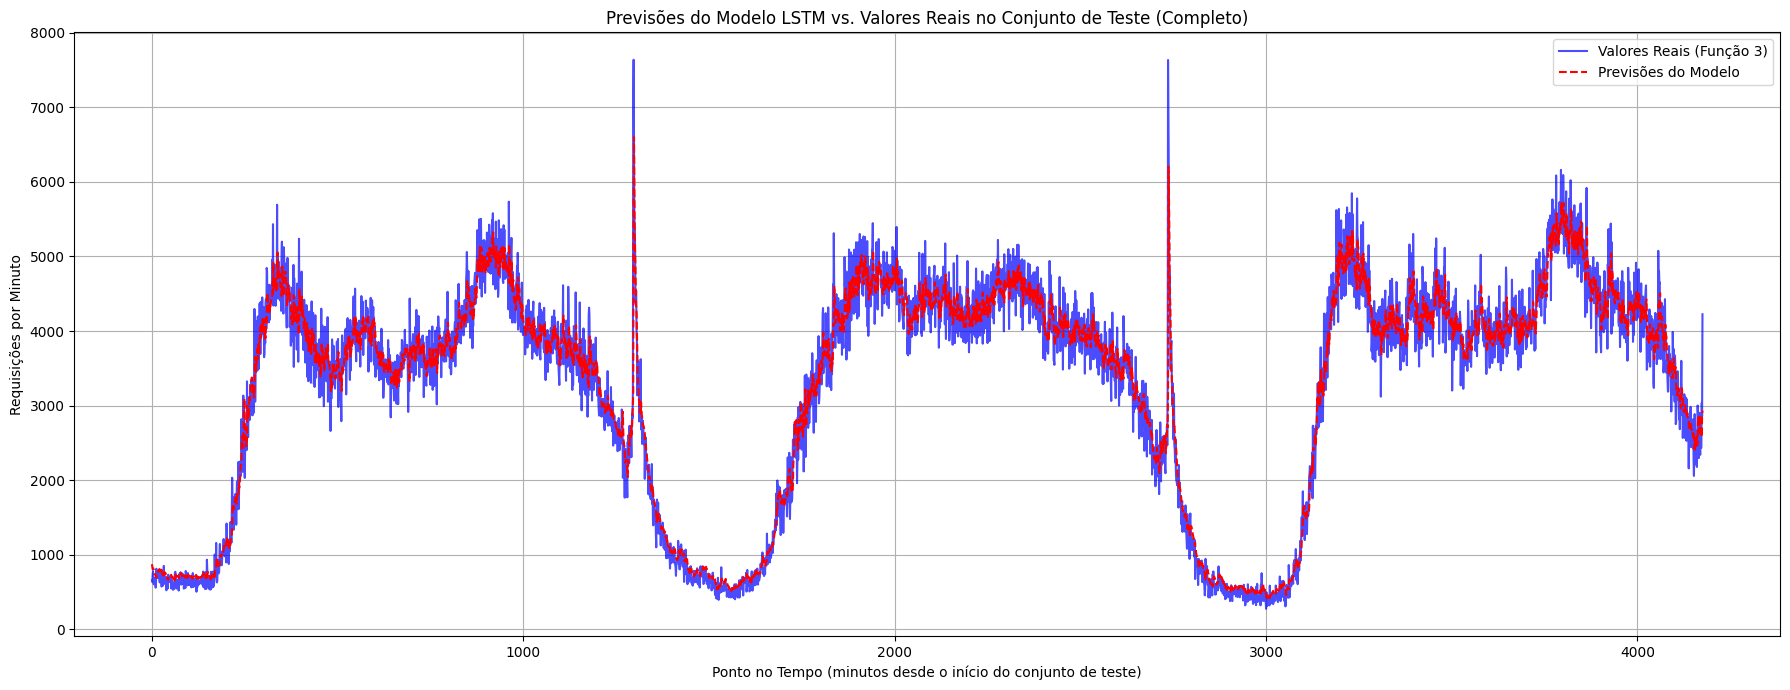

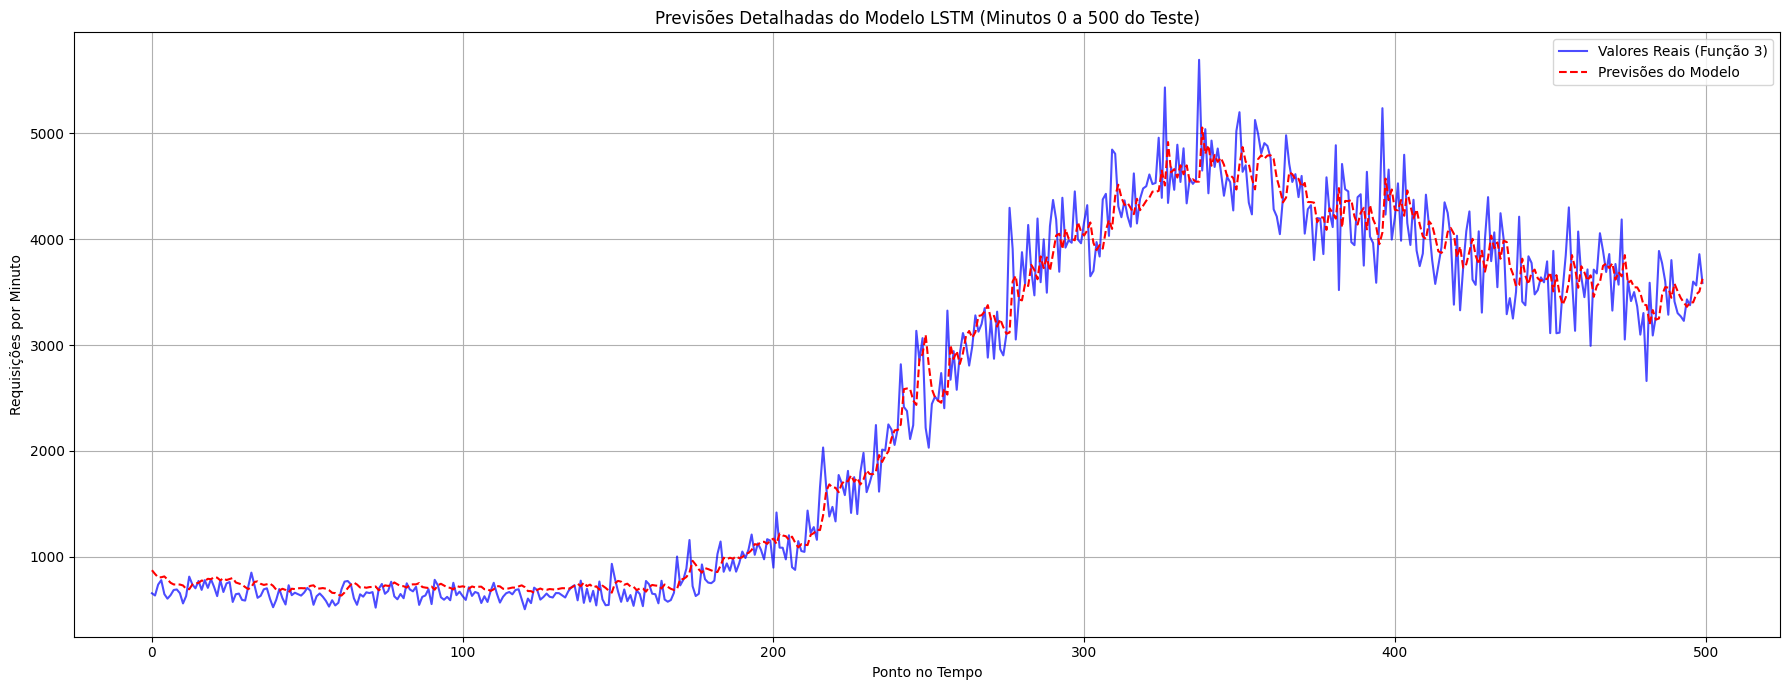

In [31]:
import matplotlib.pyplot as plt

# Fazer previsões
test_predictions_scaled = model.predict(X_test)

# Inverter a normalização das previsões
test_predictions = scaler.inverse_transform(test_predictions_scaled)

# Inverter a normalização dos valores reais de y_test
y_test_original_scale = scaler.inverse_transform(y_test)

# --- Primeiro Gráfico: Conjunto de Teste Completo ---
plt.figure(figsize=(18, 7)) # Aumentar o tamanho para melhor visualização
plt.plot(y_test_original_scale, label='Valores Reais (Função 3)', color='blue', alpha=0.7)
plt.plot(test_predictions, label='Previsões do Modelo', color='red', linestyle='--')
plt.title('Previsões do Modelo LSTM vs. Valores Reais no Conjunto de Teste (Completo)')
plt.xlabel('Ponto no Tempo (minutos desde o início do conjunto de teste)')
plt.ylabel('Requisições por Minuto')
plt.legend()
plt.grid(True)
plt.tight_layout() # Ajusta o layout para evitar sobreposição
plt.show()

start_idx = 0
end_idx = 500 

plt.figure(figsize=(18, 7))
plt.plot(y_test_original_scale[start_idx:end_idx], label='Valores Reais (Função 3)', color='blue', alpha=0.7)
plt.plot(test_predictions[start_idx:end_idx], label='Previsões do Modelo', color='red', linestyle='--')
plt.title(f'Previsões Detalhadas do Modelo LSTM (Minutos {start_idx} a {end_idx} do Teste)')
plt.xlabel('Ponto no Tempo')
plt.ylabel('Requisições por Minuto')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()